Testing the Gaia Challenge simulated data in the case on a non costant or fixed anisotropy in the velocity of the stellar subcomponent. The profile adopted is the Osipkov-Merritt, which reads:
\begin{equation}
\beta(r)=\frac{r^2}{r^2+r^2_a}
\end{equation}
with $r_a = r_h$.

The stellar profile adopted here reads:
\begin{equation}
\nu_\ast(r) = \rho_h \left(\frac{r}{r_h}\right)^{-\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^{\alpha_\ast}\right)^\frac{\gamma_\ast-\beta_\ast}{\alpha_\ast}
\end{equation}
with parameters values:
* $\alpha_\ast$ = 2
* $\beta_\ast$ = 5
* $r_h$ = 0.1,0.25,1 kpc

leading to the simple expression
\begin{equation}
\nu_\ast(r) = \frac{\rho_h}{\left(\frac{r}{r_h}\right)^{\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^2\right)^{\frac{5-\gamma_\ast}{2}}}
\end{equation}

for $\gamma_\ast = 0.1,1$ this is referred to as "Plummer" and "non-Plummer" stellar profile, respectively.

In the non-Plummer profile case, the surface brightness profile has the following analytic expression:
\begin{equation}
I(R) = 2 \int^\infty_R \frac{\nu_\ast(r) r dr}{\sqrt{r^2-R^2}} = \rho_h \frac{r_h^2\left[(2r_h^2+R^2) csch^{-1}\left(\frac{R}{r_h}\right) - r_h\sqrt{r_h^2+R^2}\right]}{(r_h^2+R^2)^{3/2}}
\end{equation}

The $line-of-sight$ velocity dispersion $\sigma^2(R)$ that enters the Likelihood has the following expression
\begin{equation}
\sigma^2_{l.o.s.}(R) = 2G\mu_0\frac{R}{I(R)}\int^\infty_1 \left(1+\frac{\beta(zR)}{z^2}\right)\frac{z}{\sqrt{z^2-1}}\int^\infty_{zR}\left(\frac{s}{zR}\right)^{2\beta(s)}\frac{\nu_\ast(s)\mu(s/r_0)}{s^2}dsdz
\end{equation}

In [1]:
import yaml
import numpy as np
from os import mkdir
from sys import argv
from AT import get_data
from scipy import special
from matplotlib import pylab as plt
from scipy.integrate import quad
from math import sqrt,cos, log10, pi
from scipy import optimize as sciopt
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import interp1d as interp
from functions_simOM import integral2, Jfactor,nu
from multiprocessing import Pool
%matplotlib inline

In [2]:
# enter size of Mock dataset (options 100,1000,10000)
MockSize = 100

In [15]:
# inverse hyperbolic cosecant (used for gamma* = 1 , non-Plum)
def inv_csch(x):
    return np.log(np.sqrt(1+x**-2.)+x**-1.)
# integrand of I(R) (used for gamma* = 0.1 , Plum)
def integrand_I(r,rh,R):
    return nu(r,rh)*r/np.sqrt(r**2-R**2)

# dwarf surface brightness profile
def I(R,rh):
    return rh**2*((2*rh**2+R**2)*inv_csch(R/rh)-rh*np.sqrt(rh**2+R**2))/(rh**2+R**2)**(3/2.) # for gamma*=1 , non-Plum
    #return 2*quad(integrand_I,R,+np.inf,args=(rh,R))[0] # for gamma*=0.1 , Plum

In [16]:
# Mock data preparation
homedir = '/home/andrea/Desktop/work/DWARF/Jvalue/output/test/'
casedir = 'OsipkMerr_Cusp_nonPlum'
data = '/gs100_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_0.dat'%MockSize
err  = '/gs100_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_0_err.dat'%MockSize
x,y,z,vx,vy,vz = np.loadtxt(homedir+casedir+data,unpack=True)
R = np.sqrt(x**2+y**2) # assumed direction of observation along z-axis for simplicity (as suggested on the Gaia wiki)
D=50.
d = np.sqrt(x**2+y**2+(D-z)**2)
v = (x*vx+y*vy+(D-z)*vz)/d
# Errors (from mock data) preparation
Evx,Evy,Evz = np.loadtxt(homedir+casedir+err,unpack=True,usecols=(3,4,5))
Ex,Ey,Ez = np.absolute(Evx-vx),np.absolute(Evy-vy),np.absolute(Evz-vz)
Ev = (x*Ex+y*Ey+(D-z)*Ez)/d

In [17]:
u=0.
rh=0.25
true_ra=rh
nstars=np.size(R)
dv = Ev

In [18]:
A_array = np.array([Ri/I(Ri,rh) for Ri in R])
r0_array = np.logspace(-4,4,200)
#ra_array = np.logspace(-4,4,100)
#I_array=np.zeros(shape=(len(A_array),len(ra_array),len(r0_array)))
I_array=np.zeros(shape=(len(A_array),len(r0_array)))

In [19]:
'''
def array_builder(r0_array, ra_array, rh, R_array):
    for i,R in enumerate(R_array):
        for j,ra in enumerate(ra_array):
            for k,r0 in enumerate(r0_array):
                yield (i, j, k), (R, ra, rh, r0)
'''
def array_builder(r0_array, ra, rh, R_array):
    for i,R in enumerate(R_array):
        for j,r0 in enumerate(r0_array):
            yield (i, j), (R, ra, rh, r0)

def proxy(args):
    return args[0], integral2(*args[1])*A_array[args[0][0]]

In [20]:
import time
start = time.time()
pool = Pool(processes=4)
#results = pool.map(proxy, array_builder(r0_array, ra_array, rh, R))
results = pool.map(proxy, array_builder(r0_array, true_ra, rh, R))
pool.close()
pool.join()
for idx,value in results:
    I_array[idx] = value
end = time.time()

In [21]:
(end-start)/60.

1.6549039363861084

In [22]:
#np.save('IarrayOMCunP100_44',I_array)
#I_array = np.load('IarrayOMCunP100_55.npy')

In [23]:
cst = 8.*np.pi*4.3e-6
# Likelihood definition (for free beta)
'''
def logLike(M0,i,j):
    I = cst*M0*I_array[:,i,j]
    S = dv**2.+I
    res = (np.log(S) + (v-u)**2./S).sum()
    return res/2.
'''
def logLike(M0,i):
    I = cst*M0*I_array[:,i]
    S = dv**2.+I
    res = (np.log(S) + (v-u)**2./S).sum()
    return res/2.

In [24]:
# |J-J(rho0,r0)| for J inversion (in log scale)
log10Jrho1 = np.log10([Jfactor(D,np.inf,r0,1.,0.5) for r0 in r0_array])
def deltaJ(log10rho0,log10J,j):
    return abs(log10J-log10Jrho1[j]-2*log10rho0)

/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty c

(0.001, 1.0)

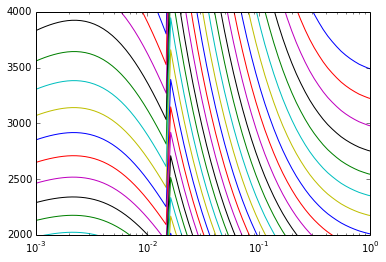

In [25]:
J_array = np.linspace(15.,25.,100)
LikeJ = np.zeros_like(r0_array)
J_new = np.empty([0])
min_LikeJ = np.empty([0])
div = np.size(r0_array)/10
acc = 3#round(log10(np.size(R)),1)
for J in J_array:
    min_r0 = np.zeros(shape=(div,2))
    for j,r0 in enumerate(r0_array):
        log10rho0 = sciopt.minimize_scalar(deltaJ,args=(J,j)).x
        LikeJ[j] = logLike(10**log10rho0*r0**3,j)
    spline_LikeJ = interp(r0_array,LikeJ)
    
    a, b = 0, div-1
    for i in range(10):
        loc_min_r0 = sciopt.minimize_scalar(spline_LikeJ,method='Bounded',bounds=(r0_array[a],r0_array[b]))
        if (r0_array[a]+r0_array[a+1])/acc<loc_min_r0.x<(r0_array[b-1]+r0_array[b])/acc: # for 1000 stars change to 3
            min_r0[i,:] = (loc_min_r0.x,loc_min_r0.fun)
        a = b
        b += div
        
    min_r0 = np.delete(min_r0,np.where(min_r0==0.),axis=0)
    new_min_r0 = np.array([min_r0[i] for i in sorted(range(len(min_r0)),key = lambda k : min_r0[k,1])])
    if new_min_r0.size!=0:
        plt.semilogx(r0_array,spline_LikeJ(r0_array),label='J=%.2f'%J)
        plt.plot(new_min_r0[0,0],new_min_r0[0,1],'*',markersize=10,c='k')
        min_LikeJ = np.append(min_LikeJ,new_min_r0[0,1])
        J_new = np.append(J_new,J)
plt.ylim(2e3,4e3)
plt.xlim(1e-3,1e0)

In [26]:
'''
J_array = np.linspace(15,25,100)
LikeJ = np.zeros_like(ra_array)
J_new = np.empty([0])
min_LikeJ = np.empty([0])
min_ra_arr = np.empty([0])
div = 10
for J in J_array:                                                # scan over an array of J values
    LikeJbeta = np.empty([0])
    r0_new = np.empty([0])
    ra_new = np.empty([0])
    min_r0 = np.zeros(shape=(div,2))
    for j,r0 in enumerate(r0_array):                             # for each J, scan over an array of r0 values
        log10rho0 = sciopt.minimize_scalar(deltaJ,args=(J,j)).x  # for each r0, find the correspongin rho0 yielding J
        min_ra = np.zeros(shape=(div,2))
        for i,ra in enumerate(ra_array):                         # for each (r0,rho0), scan over ra parameter
            LikeJ[i] = logLike(10**log10rho0*r0**3,i,j)          # evaluate the likelihood
        spline_LikeBeta = interp(ra_array,LikeJ)                 # build the profile likelihood along ra
        
        a, b = 0, 9
        for i in range(div):                                     # adaptive minima finding routine along ra
            loc_min_ra = sciopt.minimize_scalar(spline_LikeBeta,method='Bounded',bounds=(ra_array[a],ra_array[b]))
            #if ra_array[a+1]/2.<loc_min_ra.x<ra_array[b-1]/2.: min_ra[i,:] = (loc_min_ra.x,loc_min_ra.fun)
            min_ra[i,:] = (loc_min_ra.x,loc_min_ra.fun)
            a = b
            b += 10
        
        min_ra = np.delete(min_ra,np.where(min_ra==0.),axis=0)
        new_min_ra = np.array([min_ra[i] for i in sorted(range(len(min_ra)),key = lambda k : min_ra[k,1])])
        cond, i = True, 0
        while cond and i<len(min_ra):                    # find the lowest minimum (in the ranges examined)
            if ra_array[1]<new_min_ra[i,0]<ra_array[-2]:
                #plt.semilogx(ra_array,spline_LikeBeta(ra_array),label='J=%.2f'%J)
                #plt.plot(new_min_ra[i,0],new_min_ra[i,1],'*',markersize=10,c='k')
                LikeJbeta = np.append(LikeJbeta,new_min_ra[i,1])
                ra_new = np.append(ra_new,new_min_ra[i,0])
                r0_new = np.append(r0_new,r0)
                cond = False
            else:
                i += 1
    
    if np.size(r0_new)>3:
        spline_ra = interp(r0_new,ra_new)
        spline_LikeJ = interp(r0_new,LikeJbeta)
        
        if np.size(r0_new)/10==10: div2=10
        else: div2=np.size(r0_new)/10+1
        c, d = 0, np.size(r0_new)/10
        for i in range(div2):                            # adaptive minima finding routine along r0
            if d>=np.size(r0_new): d=-1
            loc_min_r0 = sciopt.minimize_scalar(spline_LikeJ,method='Bounded',bounds=(r0_new[c],r0_new[d]))
            min_r0[i,:] = (loc_min_r0.x,loc_min_r0.fun)
            c = d
            d += 10
        
        new_min_r0 = np.array([min_r0[i] for i in sorted(range(div),key = lambda k : min_r0[k,1])])
        cond, j = True, 0
        while cond and j<div2:                                   # find the lowest minimum (in the ranges examined)
            if r0_new[1]<new_min_r0[j,0]<r0_new[-2]:
                plt.semilogx(r0_new,spline_LikeJ(r0_new),label='J=%.2f'%J)
                plt.plot(new_min_r0[j,0],new_min_r0[j,1],'*',markersize=10,c='k')
                min_ra_arr = np.append(min_ra_arr,spline_ra(new_min_r0[j,0]))
                min_LikeJ = np.append(min_LikeJ,new_min_r0[j,1])
                J_new = np.append(J_new,J)
                cond = False
            else:
                j += 1
'''
#plt.ylim(240,260)
#plt.xlim(1e-3,1e2)
#plt.legend(bbox_to_anchor=(1.4,1)

"\nJ_array = np.linspace(15,25,100)\nLikeJ = np.zeros_like(ra_array)\nJ_new = np.empty([0])\nmin_LikeJ = np.empty([0])\nmin_ra_arr = np.empty([0])\ndiv = 10\nfor J in J_array:                                                # scan over an array of J values\n    LikeJbeta = np.empty([0])\n    r0_new = np.empty([0])\n    ra_new = np.empty([0])\n    min_r0 = np.zeros(shape=(div,2))\n    for j,r0 in enumerate(r0_array):                             # for each J, scan over an array of r0 values\n        log10rho0 = sciopt.minimize_scalar(deltaJ,args=(J,j)).x  # for each r0, find the correspongin rho0 yielding J\n        min_ra = np.zeros(shape=(div,2))\n        for i,ra in enumerate(ra_array):                         # for each (r0,rho0), scan over ra parameter\n            LikeJ[i] = logLike(10**log10rho0*r0**3,i,j)          # evaluate the likelihood\n        spline_LikeBeta = interp(ra_array,LikeJ)                 # build the profile likelihood along ra\n        \n        a, b = 0, 9\n     

In [27]:
interp_like = interp(J_new,min_LikeJ)
spline_LikeJ = spline(J_new,interp_like(J_new))
min_J = sciopt.minimize_scalar(spline_LikeJ,method='Bounded',bounds=(J_new[0],J_new[-1])).x
#spline_Like_ra = interp(J_new,min_ra_arr)
#min_ra = spline_Like_ra(min_J)

In [28]:
print 'min J = ',round(min_J,2)#,' , ra = ',round(min_ra,2)

min J =  19.37


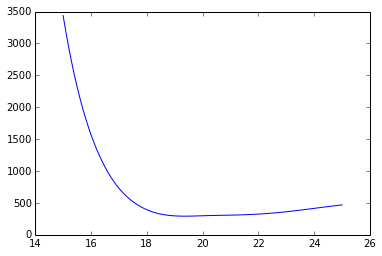

In [29]:
plt.plot(J_new,spline_LikeJ(J_new))

In [30]:
def one_sigmaJ(J):
    return np.abs(spline_LikeJ(J)-spline_LikeJ(min_J)-0.5)

one_sigma_l = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(min_J-2,min_J)).x-min_J
one_sigma_r = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(min_J,min_J+2)).x-min_J

def two_sigmaJ(J):
    return np.abs(spline_LikeJ(J)-spline_LikeJ(min_J)-2.)

two_sigma_l = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(min_J-2,min_J)).x-min_J
two_sigma_r = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(min_J,min_J+2)).x-min_J

def three_sigmaJ(J):
    return np.abs(spline_LikeJ(J)-spline_LikeJ(min_J)-4.)

three_sigma_l = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(min_J-2,min_J)).x-min_J
three_sigma_r = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(min_J,min_J+2)).x-min_J

In [31]:
print round(min_J,2),round(one_sigma_l,2),round(one_sigma_r,2),round(two_sigma_l,2),\
round(two_sigma_r,2),round(three_sigma_l,2),round(three_sigma_r,2)

19.37 -0.13 0.14 -0.25 0.3 -0.35 0.45


In [32]:
trueJ = round(np.log10(Jfactor(D,np.inf,1.,6.4e7,0.5)),2)
print 'true J : ',trueJ,', obtained J : ',round(min_J,2)

true J :  19.36 , obtained J :  19.37


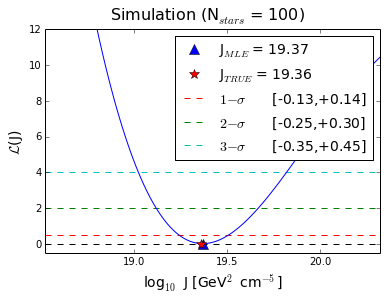

In [35]:
J_plt = np.linspace(min_J+three_sigma_l-0.5,min_J+three_sigma_r+0.5,100)
plt.plot(J_plt,spline_LikeJ(J_plt)-spline_LikeJ(min_J))
plt.plot(min_J,0,'b^',markersize=10,label='J$_{MLE}$ = %.2f'%min_J)#+r' , $r^{MLE}_a$ = %.2f'%round(min_ra,2))
plt.plot(trueJ,0,'r*',markersize=10,label='J$_{TRUE}$ = %.2f'%trueJ)#+r' , $r^{TRUE}_a$ = %.2f'%ra)
plt.hlines(0.,min(J_plt),max(J_plt),linestyles='dashed')
plt.hlines(.5,min(J_plt),max(J_plt),colors=('r'),linestyles='dashed',
           label=r'$1-\sigma$'+'\t'+'[%.2f,%+.2f]'%(one_sigma_l,one_sigma_r))
plt.hlines(2,min(J_plt),max(J_plt),colors=('g'),linestyles='dashed',
           label=r'$2-\sigma$'+'\t'+'[%.2f,%+.2f]'%(two_sigma_l,two_sigma_r))
plt.hlines(4,min(J_plt),max(J_plt),colors=('c'),linestyles='dashed',
           label=r'$3-\sigma$'+'\t'+'[%.2f,%+.2f]'%(three_sigma_l,three_sigma_r))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.ylabel(r'$\mathcal{L}$(J)',fontsize=14)
plt.xlabel(r'log$_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-0.5,12)
plt.xlim(min_J+three_sigma_l-0.5,min_J+three_sigma_r+0.5)
#plt.savefig(homedir+casedir+'/Simulations%s.png'%nstars,dpi=300,format='png')
plt.suptitle(r'Simulation (N$_{stars}$ = %i)'%nstars,fontsize=16)
plt.savefig(homedir+casedir+'/Simulation%i_test.png'%nstars,dpi=300,format='png')

In [34]:
print '%.2e'%10**sciopt.minimize_scalar(lambda log10rho0:abs(min_J-
                                                             np.log10(Jfactor(D,np.inf,1.,1.,0.5))-2*log10rho0)).x

6.51e+07
